In [ ]:
# project: final
# submitter: ssagaram

In [120]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from zipfile import ZipFile
import io
from io import TextIOWrapper
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML

# Pre-Processing

In [121]:
df = pd.read_csv("Active_Living_Index_Composite_Score.csv")
df = df[df["ALC_Score"] != 0] # not accounting for ALC_Scores of 0, as there are many missing values indicated
df = df.dropna() # dropping all rows with missing values
df

,OBJECTID,ALC_Score,BLOS_SCORE,DEST_SCORE,INTER_SCORE,JOBS_SCORE,POP_SCORE,TRANSIT_SCORE,BIKE_SCORE
162,104162,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
163,104163,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
164,104164,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
165,104165,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
166,104166,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
108043,212043,4.5,0.0,0.0,3,0.0,0.5,0.0,1.0
108044,212044,3.0,0.0,0.0,1,0.0,0.5,0.5,1.0
108045,212045,3.0,0.0,0.0,1,0.0,1.0,0.0,1.0
108046,212046,3.5,0.0,0.0,2,0.0,0.5,0.0,1.0


# Figure 1: Descriptive Stats

Text(0.5, 1.0, 'Figure 1: Bike and Transit Scores versus their ALC Score')

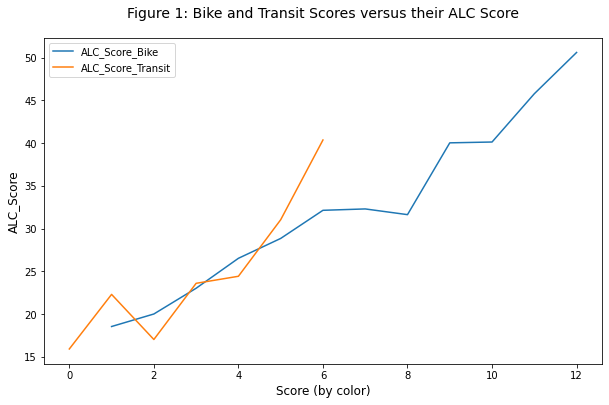

In [135]:
plt.rcParams["figure.figsize"] = [10, 6] # adapted from: https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

df_bike = df.copy()[["BIKE_SCORE","ALC_Score"]]
df_bike = df_bike.groupby(['BIKE_SCORE'],as_index=False).mean()
df_bike = df_bike.rename(columns={"BIKE_SCORE": "BIKE_SCORE", "ALC_Score": "ALC_Score_Bike"})

df_transit = df.copy()[["TRANSIT_SCORE","ALC_Score"]]
df_transit = df_transit.groupby(['TRANSIT_SCORE'],as_index=False).mean()
df_transit = df_transit.rename(columns={"TRANSIT_SCORE": "TRANSIT_SCORE", "ALC_Score": "ALC_Score_Transit"})

df_transit = df_transit.drop(columns='TRANSIT_SCORE')
ax = df_bike.plot(x="BIKE_SCORE", y="ALC_Score_Bike", rot=0)
df_transit.plot(ax=ax)
plt.xlabel("Score (by color)", fontsize="12")
plt.ylabel("ALC_Score", fontsize="12")
plt.title("Figure 1: Bike and Transit Scores versus their ALC Score", pad=20, fontsize="14")

# Figure 2: Unsupervised ML

In [123]:
df_kmeans = df.copy()
df_kmeans.head()

,OBJECTID,ALC_Score,BLOS_SCORE,DEST_SCORE,INTER_SCORE,JOBS_SCORE,POP_SCORE,TRANSIT_SCORE,BIKE_SCORE
162,104162,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
163,104163,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
164,104164,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
165,104165,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0
166,104166,5.0,0.0,0.0,3,0.0,1.0,0.0,1.0


In [124]:
scores = pd.Series(dtype=float)
for k in range(1, 10):
    km = KMeans(n_clusters=k)
    km.fit(df_kmeans)
    scores.loc[k] = km.inertia_

Text(0.5, 1.0, 'Figure 2: Cumulative Inertia through KMeans Analysis')

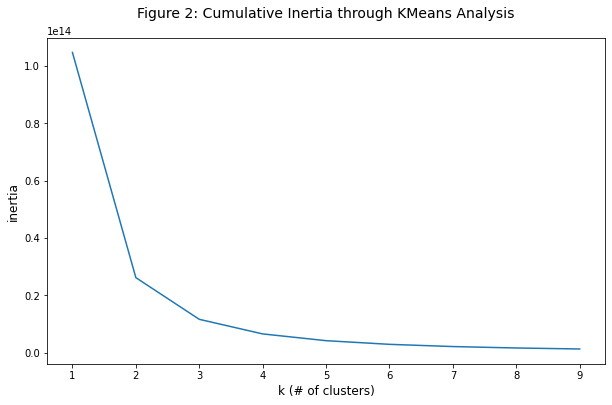

In [125]:
ax = scores.plot.line()
ax.set_xlabel("k (# of clusters)", fontsize="12")
ax.set_ylabel("inertia", fontsize="12")
ax.set_title("Figure 2: Cumulative Inertia through KMeans Analysis", pad=20, fontsize="14")

# Figure 3: Supervised ML

In [127]:
df_supervised = df.copy()
train, test = train_test_split(df_supervised, random_state=0)
test

,OBJECTID,ALC_Score,BLOS_SCORE,DEST_SCORE,INTER_SCORE,JOBS_SCORE,POP_SCORE,TRANSIT_SCORE,BIKE_SCORE
78084,182084,26.3,1.8,8.0,12,0.0,1.5,0.0,3.0
53847,157847,41.5,2.4,15.6,13,4.5,1.0,2.0,3.0
66901,170901,24.7,3.0,7.2,10,2.5,1.0,0.0,1.0
40009,144009,21.2,1.2,0.0,5,3.5,0.5,5.0,6.0
86461,190461,14.9,2.4,0.0,9,1.5,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
80579,184579,27.2,3.0,3.2,11,2.5,1.0,3.5,3.0
35822,139822,23.4,2.4,0.0,13,2.5,1.0,3.5,1.0
63358,167358,36.4,2.4,12.0,9,3.0,1.0,5.0,4.0
98232,202232,49.0,3.0,24.0,15,0.5,1.0,1.5,4.0


array([ 1.2194927 ,  1.71956633,  1.71368434, -0.00726901,  0.05639061,
       -0.01467292,  0.0901858 ,  0.03150391, -0.00987015])

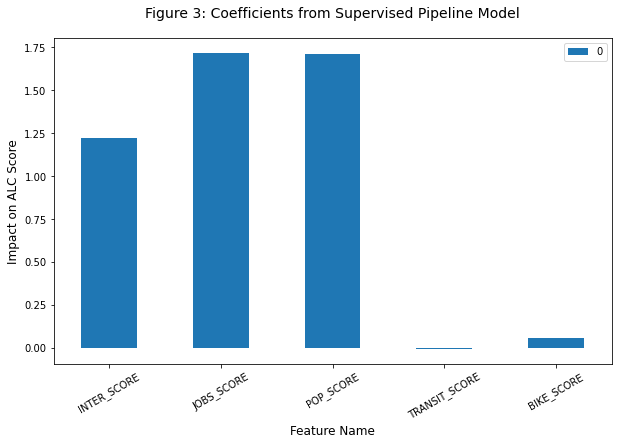

In [134]:
model_compl = Pipeline([
    ("both", make_column_transformer((PolynomialFeatures(degree=2, include_bias = False), ["BIKE_SCORE","TRANSIT_SCORE","INTER_SCORE"]))),                                    
    ('lr', LinearRegression())
])
model_compl.fit(train[["INTER_SCORE","JOBS_SCORE","POP_SCORE","TRANSIT_SCORE","BIKE_SCORE"]], train["ALC_Score"])
df_copy = test.copy()
df_copy["predicted"] = model_compl.predict(test[["INTER_SCORE","JOBS_SCORE","POP_SCORE","TRANSIT_SCORE","BIKE_SCORE"]])
model_compl.score(test[["INTER_SCORE","JOBS_SCORE","POP_SCORE","TRANSIT_SCORE","BIKE_SCORE"]], test["ALC_Score"])
coefficients = pd.DataFrame(model_compl['lr'].coef_)
coefficients = coefficients.rename(index={0: "INTER_SCORE", 1: "JOBS_SCORE", 2: "POP_SCORE", 3:"TRANSIT_SCORE", 4: "BIKE_SCORE"})
coefficients[0:5].plot.bar(rot=30)
plt.xlabel("Feature Name", fontsize="12")
plt.ylabel("Impact on ALC Score", fontsize="12")
plt.title("Figure 3: Coefficients from Supervised Pipeline Model", pad=20, fontsize="14")


model_compl['lr'].coef_